<a href="https://www.kaggle.com/code/clemwo/time-series-understanding-autocorrelation?scriptVersionId=239694959" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

✨✨This notebook is the **1st** notebook of my **🧠 Timeseries Series ⏱️**, where I am trying to dive into time series and the mathematics of common techniques. 

In [1]:
import numpy as np 
import pandas as pd 

import os
import copy
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import statsmodels.api as sm

from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
from statsmodels.graphics.tsaplots import plot_acf

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

plt.style.use('ggplot')

/kaggle/input/time-series-starter-dataset/Month_Value_1.csv


# 🧠Time Series ⏱️ Understanding (Partial) Autocorrelation🌀

In this notebook we dive into the mathematics autocorrelation, partial autocorrelation and how to create respective plots from scratch, like the Partial Auto Correlation Function. The objective is to understand autocorrelations and it's math and fully grasp plots which we normally use for time series analysis. 

# Global Variables & Settings

In [2]:
RANDOM_SEED = 42
FACECOLOR = '#f7f4eb'

np.random.seed(RANDOM_SEED)

# Reading the Data

In [3]:
data = pd.read_csv('/kaggle/input/time-series-starter-dataset/Month_Value_1.csv')
print(f"Rows: {data.shape[0]:,}")
print(f"Cols: {data.shape[1]:,}")
pd.set_option('display.float_format', '{:,.2f}'.format)
data.head(5)

Rows: 96
Cols: 5


,Period,Revenue,Sales_quantity,Average_cost,The_average_annual_payroll_of_the_region
0,01.01.2015,"16,010,072.12","12,729.00","1,257.76","30,024,676.00"
1,01.02.2015,"15,807,587.45","11,636.00","1,358.51","30,024,676.00"
2,01.03.2015,"22,047,146.02","15,922.00","1,384.70","30,024,676.00"
3,01.04.2015,"18,814,583.29","15,227.00","1,235.61","30,024,676.00"
4,01.05.2015,"14,021,479.61","8,620.00","1,626.62","30,024,676.00"


In [4]:
data.dtypes

Period                                       object
Revenue                                     float64
Sales_quantity                              float64
Average_cost                                float64
The_average_annual_payroll_of_the_region    float64
dtype: object

# Pre-Processing

In [5]:
data = data.dropna(subset=['Revenue'])

Let's convert the time column `Period` from type object to an actual datetime. 

In [6]:
data['Period'] = pd.to_datetime(data['Period'], dayfirst=True)
data['Period'][:5]

0   2015-01-01
1   2015-02-01
2   2015-03-01
3   2015-04-01
4   2015-05-01
Name: Period, dtype: datetime64[ns]

For time series data we should set the time column as the index.

In [7]:
data.set_index('Period', inplace=True)
data['Year'] = data.index.year

In [8]:
print(data.index.min())
print(data.index.max())

2015-01-01 00:00:00
2020-04-01 00:00:00


# Exploratory Data Analysis

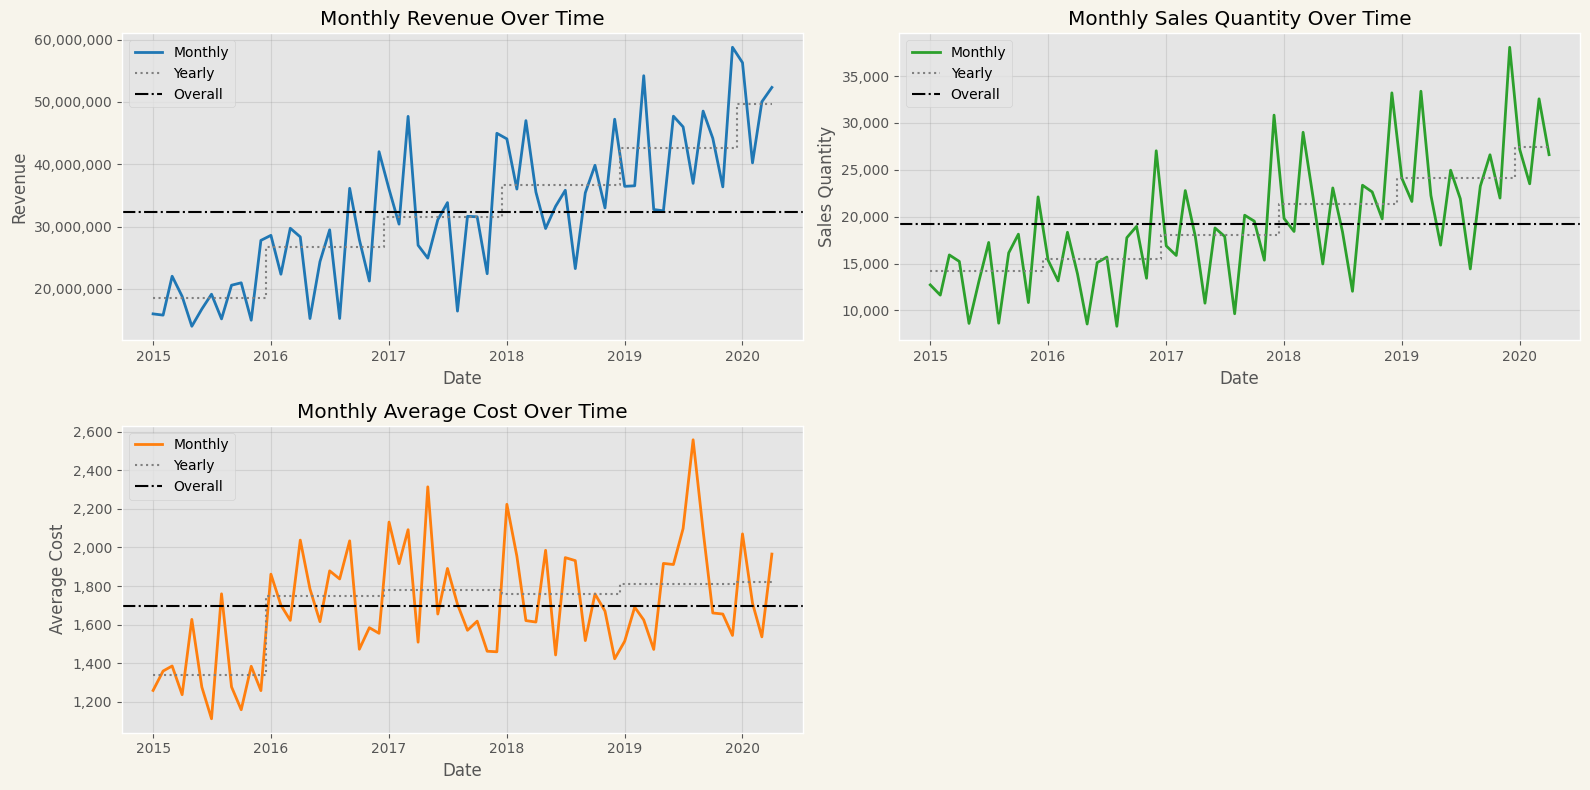

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), facecolor=FACECOLOR)
axs = axs.flatten()

def plot_metric(ax, column, color, title, ylabel):
    yearly_avg = data.groupby('Year')[column].mean()
    step_dates = pd.date_range(start=data.index.min(), end=data.index.max(), freq='MS')
    step_values = step_dates.to_series().dt.year.map(yearly_avg)
    overall_avg = data[column].mean()

    ax.plot(data.index, data[column], color=color, linewidth=2, label='Monthly')
    ax.step(step_dates, step_values, where='mid', linestyle=':', color='gray', linewidth=1.5, label='Yearly')
    ax.axhline(y=overall_avg, color='black', linestyle='-.', linewidth=1.5, label='Overall')

    ax.set_title(title)
    ax.set_xlabel('Date')
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.2, color='grey')

    formatter = FuncFormatter(lambda x, _: f'{x:,.0f}')
    ax.yaxis.set_major_formatter(formatter)
    ax.legend()

plot_metric(axs[0], 'Revenue', 'tab:blue', 'Monthly Revenue Over Time', 'Revenue')
plot_metric(axs[1], 'Sales_quantity', 'tab:green', 'Monthly Sales Quantity Over Time', 'Sales Quantity')
plot_metric(axs[2], 'Average_cost', 'tab:orange', 'Monthly Average Cost Over Time', 'Average Cost')

# Hide the unused 4th subplot
axs[3].axis('off')

plt.tight_layout()
plt.show()

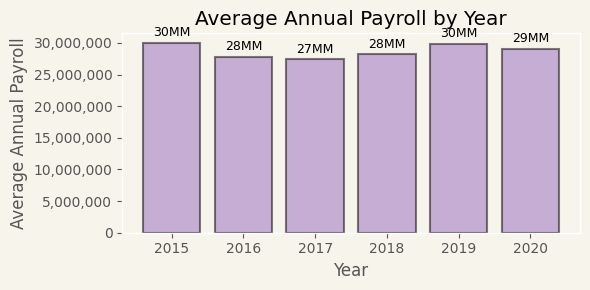

In [10]:
yearly_avg_payroll = data.groupby('Year')['The_average_annual_payroll_of_the_region'].mean()

fig = plt.figure(figsize=(6, 3), facecolor=FACECOLOR)
ax = fig.add_subplot(111, facecolor=FACECOLOR)

ax.bar(yearly_avg_payroll.index.astype(str), yearly_avg_payroll.values, 
       color='tab:purple', edgecolor='black', linewidth=1.5, alpha=0.5)

for i, v in enumerate(yearly_avg_payroll.values):
    ax.text(i, v + 0.02 * v, f'{v/1_000_000:,.0f}MM', ha='center', va='bottom', fontsize=9)

ax.set_title('Average Annual Payroll by Year')
ax.set_xlabel('Year')
ax.set_ylabel('Average Annual Payroll')
ax.grid(False)

formatter = FuncFormatter(lambda x, _: f'{x:,.0f}')
ax.yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

# Seasonal Plots

In [11]:
data['Month_name'] = data.index.strftime('%b')
data['Month_num'] = data.index.month
data['Year'] = data.index.year

## Year-over-Year and Month-over-Month

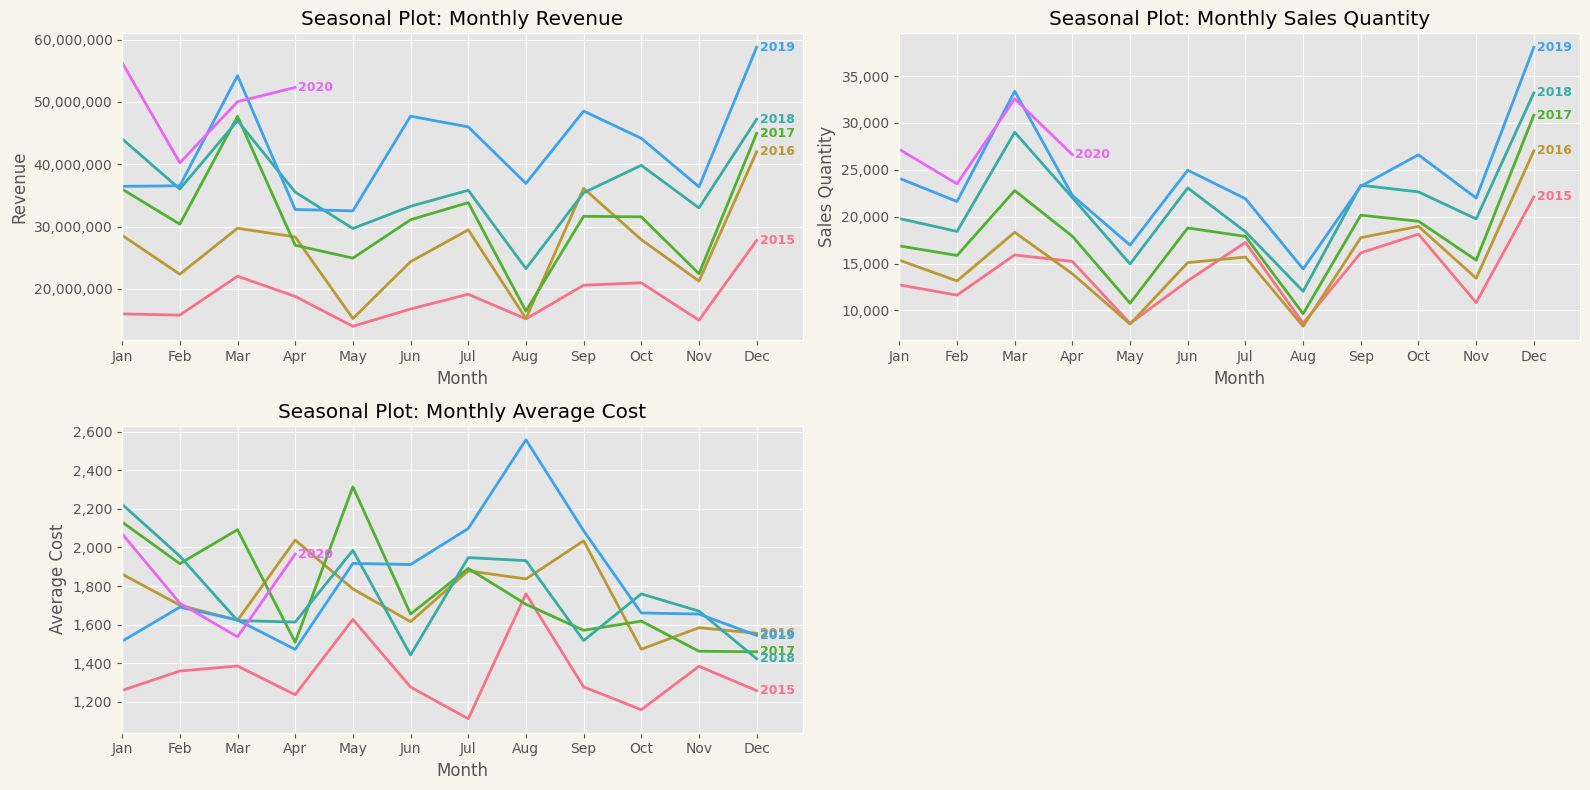

In [12]:
unique_years = data['Year'].unique()
year_palette = sns.color_palette("husl", n_colors=len(unique_years))
min_year = unique_years.min()

fig, axs = plt.subplots(2, 2, figsize=(16, 8), facecolor=FACECOLOR)

def seasonal_lineplot(ax, column, title, ylabel, color_palette):
    sns.lineplot(
        data=data,
        x='Month_num',
        y=column,
        hue='Year',
        palette=color_palette,
        linewidth=2,
        legend=False,
        ax=ax
    )
    ax.set_title(title)
    ax.set_xlabel('Month')
    ax.set_ylabel(ylabel)
    ax.set_xlim(1, 12.8)
    ax.set_xticks(range(1, 13))
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                        'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    formatter = FuncFormatter(lambda x, _: f'{x:,.0f}')
    ax.yaxis.set_major_formatter(formatter)

    for year, subset in data.groupby("Year"):
        subset_sorted = subset.sort_values("Month_num")
        subset_sorted = subset_sorted.dropna(subset=["Month_num", column])
        if subset_sorted.empty:
            continue
        x_pos = subset_sorted["Month_num"].iloc[-1]
        y_pos = subset_sorted[column].iloc[-1]
        if pd.notnull(y_pos):
            ax.text(
                x=x_pos + 0.05,
                y=y_pos,
                s=str(year),
                fontsize=9,
                weight="bold",
                color=color_palette[year - min_year],
                verticalalignment='center'
            )

seasonal_lineplot(axs[0, 0], 'Revenue', 'Seasonal Plot: Monthly Revenue', 'Revenue', year_palette)
seasonal_lineplot(axs[0, 1], 'Sales_quantity', 'Seasonal Plot: Monthly Sales Quantity', 'Sales Quantity', year_palette)
seasonal_lineplot(axs[1, 0], 'Average_cost', 'Seasonal Plot: Monthly Average Cost', 'Average Cost', year_palette)

axs[1, 1].axis('off')

plt.tight_layout()
plt.show()

$\textbf{Revenue}$

- We clearly see: the revenue is increasing year-over-year. There is a **large jump in revenue in December each year**. The graph also shows a drop in data after April 2020. This is likely due to the world-wide Corona crisis.

$\textbf{Sales Quantity}$

- We observe a similar pattern as for the revenue. Here, the year-over-year seasonal behavior is even more similar and the only difference is a higher sales count year-over-year, but the seasonal pattern stays the same.

$\textbf{Average Cost}$

- The average cost does not show as clear of a seasonal year-over-year pattern as we saw for revenue and sales. However, seasonality is still visible. 

In [13]:
data['year'] = data.index.year
data['month'] = data.index.strftime('%B')
data['month'] = pd.Categorical(
    data['month'],
    categories=[
        "January", "February", "March", "April", "May", "June",
        "July", "August", "September", "October", "November", "December"
    ],
    ordered=True
)

An alternative plot that emphasises the seasonal patterns is where the data for each season are collected together in separate mini time plots ([source](https://otexts.com/fpppy/nbs/02-graphics.html)).

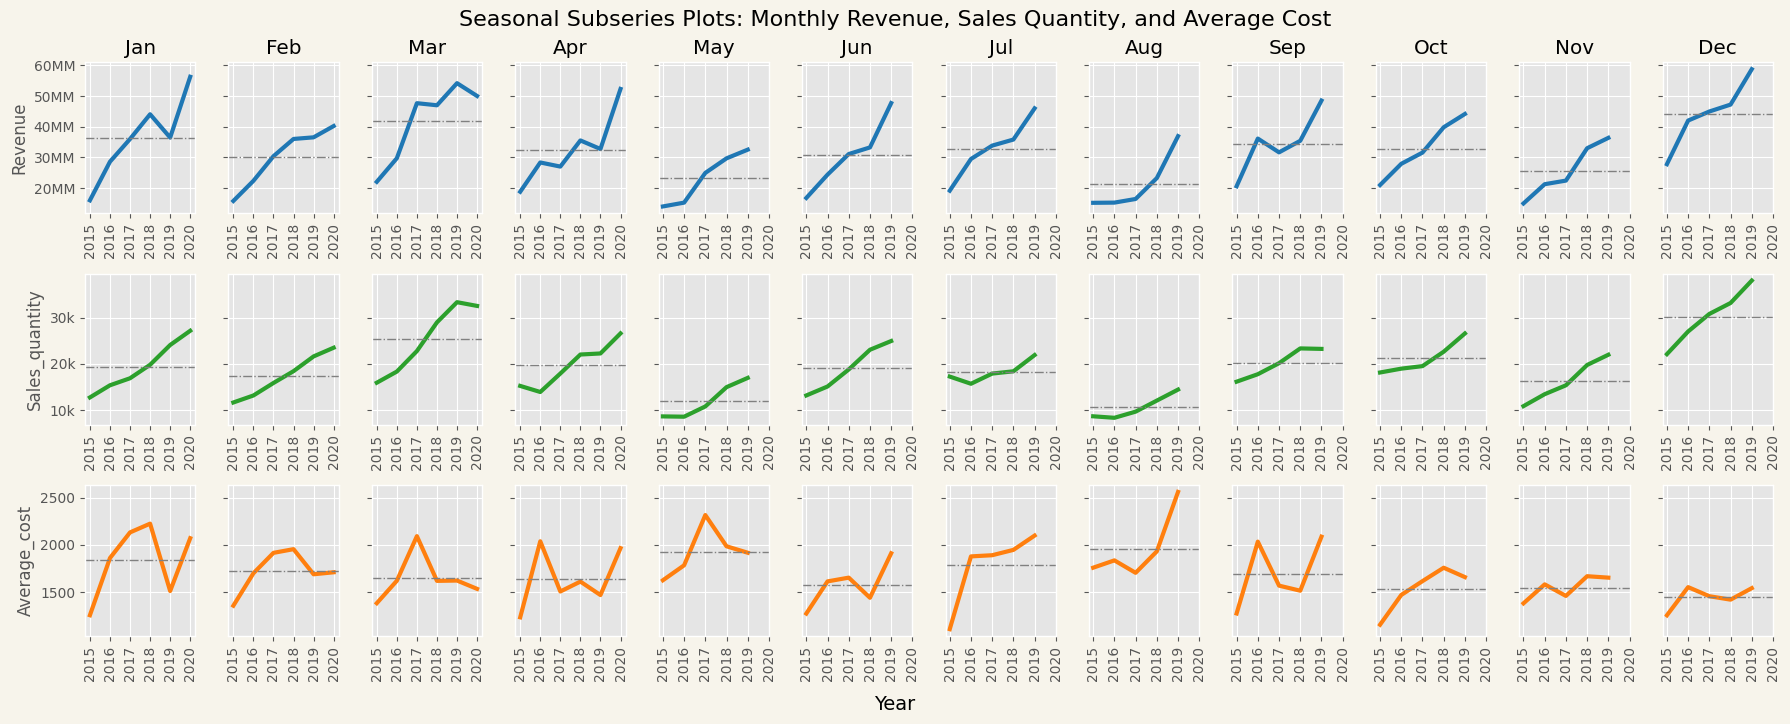

In [14]:
all_years = sorted(data['year'].unique())
months = data['month'].cat.categories
variables = [
    ('Revenue', 'tab:blue'),
    ('Sales_quantity', 'tab:green'),
    ('Average_cost', 'tab:orange'),
]

fig, axes = plt.subplots(nrows=3, ncols=12, figsize=(18, 7), sharey='row', facecolor=FACECOLOR)

for row, (var, color) in enumerate(variables):
    for col, month in enumerate(months):
        month_data = data.query("month == @month")
        mean_val = month_data[var].mean()

        ax = axes[row, col]
        ax.plot(month_data['year'], month_data[var], color=color, linewidth=3)
        ax.axhline(mean_val, color='grey', linestyle='-.', linewidth=1)

        if row == 0:
            ax.set_title(month[:3])
        if col == 0:
            ax.set_ylabel(var)
            ax.tick_params(labelleft=True)
        
            # Format y-ticks by row
            if row == 0:
                formatter = FuncFormatter(lambda x, _: f'{x/1e6:.0f}MM')
            if row == 1:
                formatter = FuncFormatter(lambda x, _: f'{x/1e3:.0f}k')
            if row in [0,1]: 
                ax.yaxis.set_major_formatter(formatter)
        else:
            ax.tick_params(labelleft=False)
        
        ax.set_xticks(all_years)
        ax.tick_params(axis='x', rotation=90)

plt.tight_layout(rect=[0, 0, 1, 0.96])
fig.suptitle("Seasonal Subseries Plots: Monthly Revenue, Sales Quantity, and Average Cost", fontsize=16)
fig.text(0.5, -0.02, "Year", ha="center", fontsize=14)
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

The grey horizontal lines indicate the means for each month. This plot enables us to see the underlying seasonal pattern even more clearly than in the previous plot. As before, but more clearly, we observe a constant year-over-year increase in revenue. Even clearer we see that this pattern holds true for each and every month.

## Quarter-over-Quarter

In [15]:
data['Quarter'] = "Q" + data.index.quarter.astype(str)
data['Year'] = data.index.year

data['Quarter'] = pd.Categorical(
    data['Quarter'],
    categories=["Q1", "Q2", "Q3", "Q4"],
    ordered=True
)

all_years = sorted(data['Year'].unique())
quarters = data['Quarter'].cat.categories

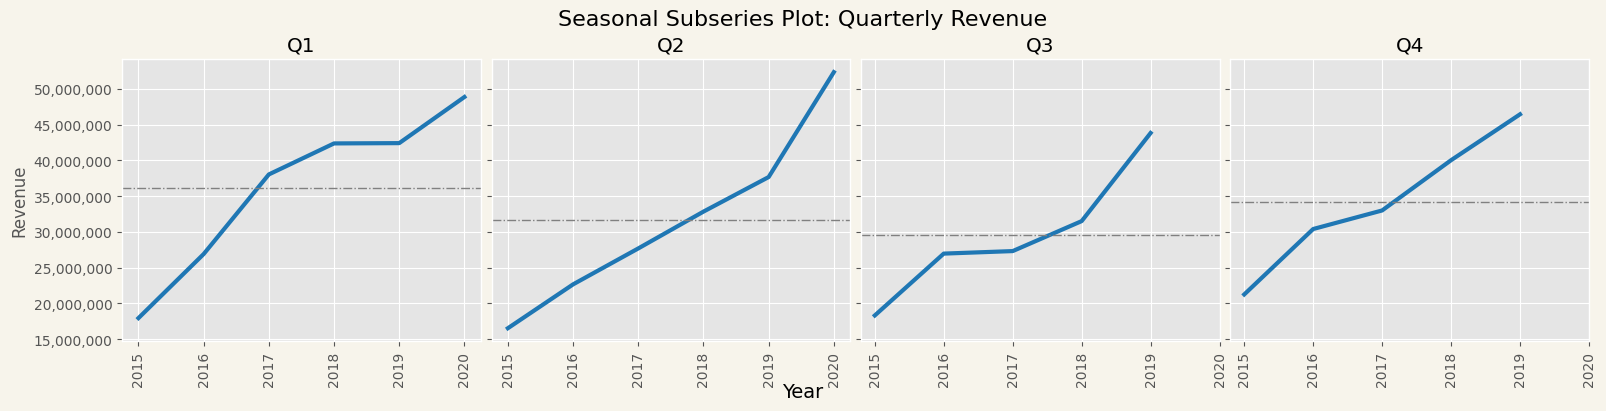

In [16]:
quarterly_avg = data.groupby(['Year', 'Quarter'])['Revenue'].mean().reset_index()

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16, 4), sharey=True, facecolor=FACECOLOR)

for i, quarter in enumerate(quarters):
    quarter_data = quarterly_avg[quarterly_avg['Quarter'] == quarter]
    mean_val = quarter_data['Revenue'].mean()

    axes[i].plot(quarter_data['Year'], quarter_data['Revenue'], color='tab:blue', linewidth=3)
    axes[i].axhline(mean_val, color='grey', linestyle='-.', linewidth=1)
    axes[i].set_title(quarter)
    axes[i].set_xticks(all_years)
    axes[i].tick_params(axis='x', rotation=90)

    if i == 0:
        axes[i].set_ylabel("Revenue")
        formatter = FuncFormatter(lambda x, _: f'{x:,.0f}')
        axes[i].yaxis.set_major_formatter(formatter)

plt.tight_layout(rect=[0, 0, 1, 0.95])

# Adjust subplot positions to reduce horizontal gaps
for ax in axes:
    pos = ax.get_position()
    ax.set_position([pos.x0 - 0.005, pos.y0, pos.width + 0.01, pos.height])

fig.suptitle("Seasonal Subseries Plot: Quarterly Revenue", fontsize=16)
fig.text(0.5, 0.01, "Year", ha="center", fontsize=14)
plt.show()

## Scatter plots

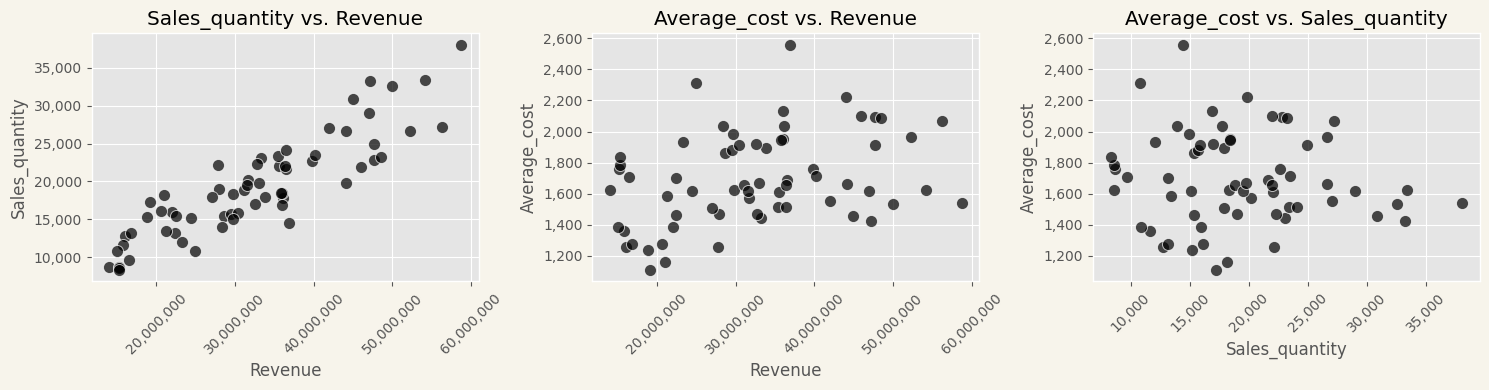

In [17]:
from itertools import combinations

vars_of_interest = ['Revenue', 'Sales_quantity', 'Average_cost']
combos = list(combinations(vars_of_interest, 2))

fig, axs = plt.subplots(1, len(combos), figsize=(5 * len(combos), 4), facecolor=FACECOLOR)

for ax, (x_var, y_var) in zip(axs, combos):
    sns.scatterplot(data=data, x=x_var, y=y_var, color='black', 
                    s=75, alpha=0.7, ax=ax)
    ax.set_title(f"{y_var} vs. {x_var}")
    ax.set_xlabel(x_var)
    ax.set_ylabel(y_var)

    ax.tick_params(axis='x', rotation=45)

    formatter = FuncFormatter(lambda x, _: f'{x:,.0f}')
    ax.yaxis.set_major_formatter(formatter)
    ax.xaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

As we could have already guessed by previous chapters insights, Revenue and Sales have a clear correlation. This also makes intuitively sense. However, average cost is not correlation with any of these two. Let's validate this by taking a look at the correlation matrix.

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


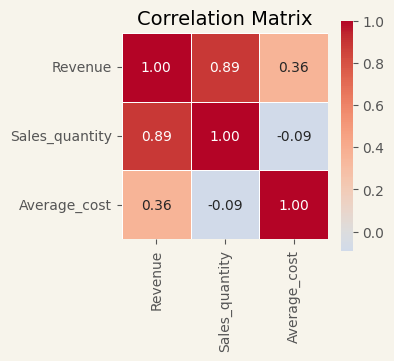

In [18]:
corr_matrix = data[vars_of_interest].corr()

plt.figure(figsize=(4, 4), facecolor=FACECOLOR)
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8},
)

plt.title("Correlation Matrix", fontsize=14)
plt.tight_layout()
plt.show()

# Lag Plots

Let's take a look at lag plot which show $y_t$ plotted against $y_{t-k}$ for different values of $k$. Note, that in our case $k$ will be in months so in the following something like `lag_7` will stand for a lag of 7 months. We will also show the [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) $r$ for each lag plot. This gives us a sense of how stronlgy $y_t$ is correlating with $y_{t-k}$.

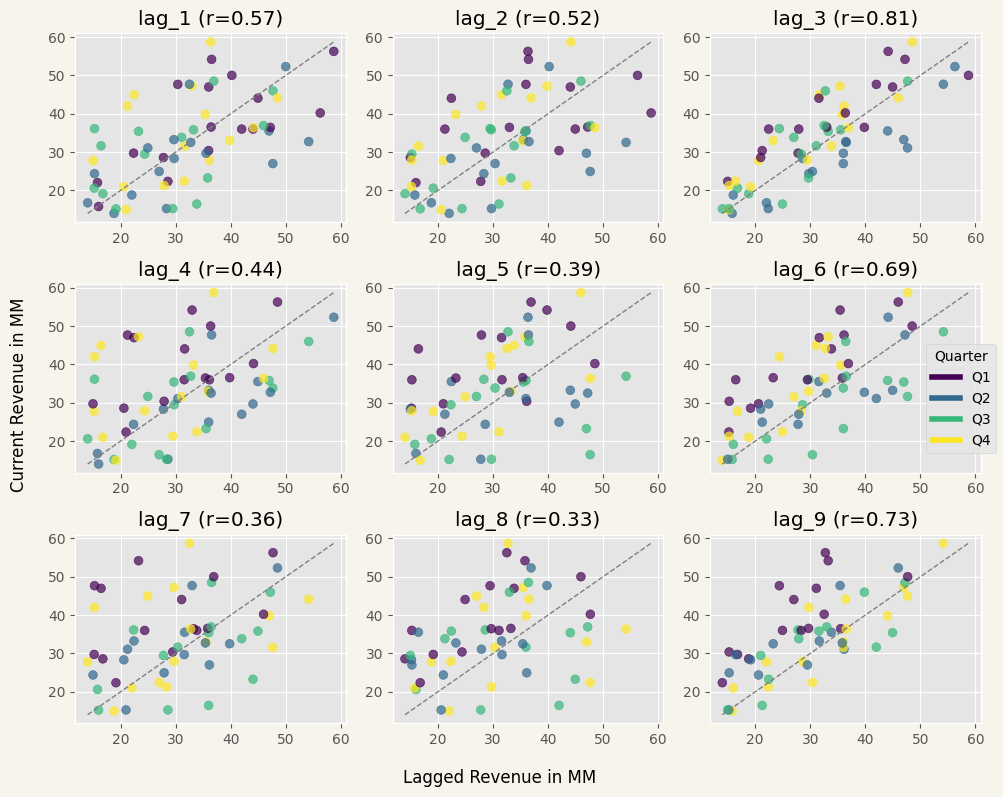

In [19]:
# ----------- #
# Preparation #
# ----------- #
revenue_df = data[['year', 'month', 'Revenue']].copy()
revenue_df['ds'] = pd.to_datetime(revenue_df['year'].astype(str) + '-' + data['month'].cat.codes.add(1).astype(str) + '-01')
revenue_df.sort_values('ds', inplace=True)
revenue_df.reset_index(drop=True, inplace=True)
revenue_df['Quarter'] = revenue_df['ds'].dt.quarter

revenue_df.rename(columns={'Revenue': 'y'}, inplace=True)
for lag in range(1, 10):
    revenue_df[f'lag_{lag}'] = revenue_df['y'].shift(lag)

# Lag columns and axis limits
lags = [f'lag_{i}' for i in range(1, 10)]
lims = [
    np.min([revenue_df[lag].min() for lag in lags] + [revenue_df['y'].min()]),
    np.max([revenue_df[lag].max() for lag in lags] + [revenue_df['y'].max()]),
]

# -------- #
# Plotting #
# -------- #
fig, axes = plt.subplots(3, 3, figsize=(10, 8), facecolor=FACECOLOR)
for ax, lag in zip(axes.flatten(), lags):
    ax.scatter(
        revenue_df[lag],
        revenue_df['y'],
        c=revenue_df['Quarter'],
        cmap='viridis',
        alpha=0.7,
        s=40,
    )
    ax.plot(lims, lims, color='grey', linestyle='--', linewidth=1)

    # Display the Pearson correlation coefficient
    r = revenue_df[[lag, 'y']].corr().iloc[0, 1]
    ax.set_title(f"{lag} (r={r:.2f})")

    formatter = FuncFormatter(lambda x, _: f'{x/1e6:.0f}')
    ax.yaxis.set_major_formatter(formatter)
    ax.xaxis.set_major_formatter(formatter)

unique_quarters = sorted(revenue_df['Quarter'].dropna().unique())
colors = plt.cm.viridis(np.linspace(0, 1, len(unique_quarters)))
handles = [plt.Line2D([0], [0], color=color, lw=4) for color in colors]
labels = [f"Q{q}" for q in unique_quarters]
fig.legend(handles, labels, title="Quarter", loc="center right")

fig.supxlabel("Lagged Revenue in MM", y=0.01, fontsize=12)
fig.supylabel("Current Revenue in MM", x=0.01, fontsize=12)

plt.tight_layout()
plt.show()

> `lag_3` has the strongest correlation with a Pearson Correlation coefficient of 0.81. This indicates a strong positive linear relationship between revenue at time $t$ and revenue 3 periods (/months) earlier $(t-3)$.

This suggests:
- `Revenue` exhibits **seasonal or cyclic behavior with a *3-month* pattern**.
- Values from 3 months ago are good predictors of current revenue.
- Business performance likely follows **quarterly dynamics** (e.g., promotions, budgeting, or demand cycles).

> Notably, `lag_6` and `lag_9` show the second and third highest correlations, which aligns with expectations—being multiples of 3, they reinforce the presence of a quarterly cycle.

> Weakest correlation is for lags 5, 7 and 8, suggesting deminishing memory for higher lags which are not multiples of three. 

We now already took a look at lagged plot which display the relationship of current time $t$ to the lagged value of itself at $(t-k)$ (for a lag of $k$). This means we observed the relationship of a variable - in our case `Revenue` - to a lagged version of itself over time. This is essentially what $\textbf{Autocorrelation}$ refers to! By that, autocorrelation tells us **how the current value depends on past values**. 

By examining how `Revenue` at time $t$ correlated with `Revenue` at earlier periods (e.g. $t-1, t-2, t-k$, etc, where $k$ was number of months), we were able to detect repeating patterns, cycles, or dependencies. In our case we saw behavior pointing to seasonality - a repeating pattern every 3 months. We saw for example that `Revenue` 3 months ago is a strong predictor of current `Revenue`.

Let's get more deep into autocorrelation.

# Autocorrelation

Previously we learned that $\textbf{Autocorrelation}$ is refering to the relationship between a variable and a lagged version of itself over time. In time series analysis we typically plot the autocorrelation value for different lags. That simply means to plot lags on the x axis against the correlation value ($r$ from above) on the y axis.

We can easily implement the $\textbf{Autocorrelation Function}$ by hand. It's simply the correlation coefficient of $y_t$ and $y_{t-k}$ for a specific lag $k$.

In [20]:
y = data['Revenue'].dropna().values
y_mean = np.mean(y)
n = len(y)

## ACF from Scratch

We don't just compute the raw Pearson correlation coefficients between the two shifted series of length $(n-lag)$, but rather need to adjust for degrees of freedom or handling bias. This way we correct for the fact that there are fewer overlapping pairs as lag increases.

We can use a **biased estimator** (dividing by $n$). This matches the common implementation of `statsmodels` when `adjusted=False`. It is mean-centered and a full-sample variance. We can define this $\textbf{Autocorrelation Function - Biased Estimator}$ as follows:

Given a time series $y={y_1, y_2, \dots, y_n}$, the **autocorrelation at lag** $k$ is: 
$$
\begin{align}
    \text{ACF}(k) &= \frac{\sum_{t=1}^{n-k}(y_t - \bar{y})(y_{t+k} - \bar{y})}{\sum_{t=1}^{n}(y_t - \bar{y})^2} \\ 
                  &= \frac{\text{Covariance between the series and its lagged version}}{\text{Variance of the full series}}
\end{align}    
$$
where 
- $\bar{y}$: mean of the series
- $n$: total number of observations
- $k$: lag (in months in our case)

The result is a **normalized measure** $\in [-1, 1]$, of how strongly the series at time $t$ is linearly related to its value at time $t-k$. 

In [21]:
def autocorrelation_function(y, lag):
    """Compute autocorrelation at a specific lag (k)."""
    y = y - np.mean(y)
    n = len(y)
    numerator = np.sum(y[:n - lag] * y[lag:])
    denominator = np.sum(y ** 2)
    return numerator / denominator

Usually we plot the ACF to see how the correlations change with the lag $k$. This kind of plot can also be called **correlogram**. Typically, one also shows the confidence interval (e.g. 95%) of all calculated autocorrelation values. In the plot this adds a shaded band to indicate where autocorrelation values would fall by chance 95% of the time. Anything outside this band is considered **statistically significant**.

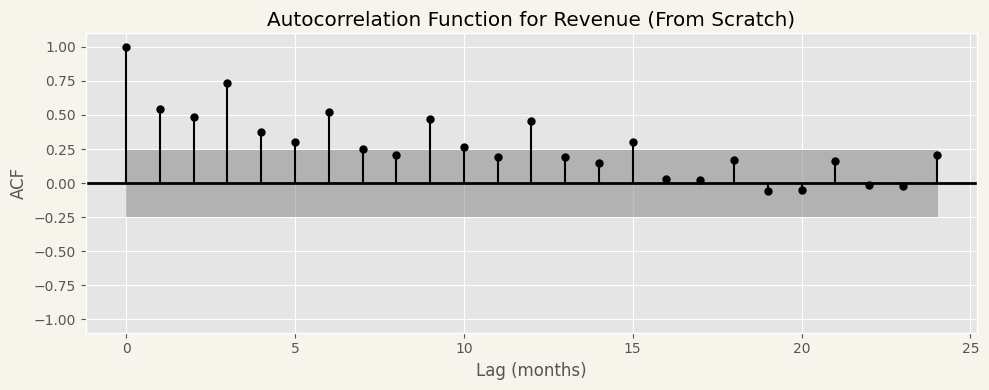

In [22]:
# Compute autocorrelations up to lag 24 (2 years)
max_lag = 24
acf_values = [1.0]  # autocorrelation at lag 0 is always 1
for lag in range(1, max_lag + 1):
    acf_values.append(autocorrelation_function(y, lag))

# Confidence interval at 95%
conf_level = 1.96 / np.sqrt(n)

plt.figure(figsize=(10, 4), facecolor=FACECOLOR)
lags = np.arange(0, max_lag + 1)
markerline, stemlines, baseline = plt.stem(
    lags, acf_values, basefmt=" ", linefmt='k-', markerfmt='ko'
)
markerline.set_markersize(5)

# Add confidence interval band
plt.fill_between(lags, conf_level, -conf_level, color='grey', 
                 alpha=0.5, label='95% CI')

plt.axhline(0, color='black', linewidth=2)
plt.title("Autocorrelation Function for Revenue (From Scratch)")
plt.xlabel("Lag (months)")
plt.ylabel("ACF")
plt.ylim(-1.1, 1.1)
plt.tight_layout()
plt.show()

## ACF from Library

Now, let's compare our previously created Autocorrelation Function (ACF) plot with one from a common library like [statsmodels](https://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_acf.html) using `graphics.tsaplots`. This way we can see if we implemented it correctly. 

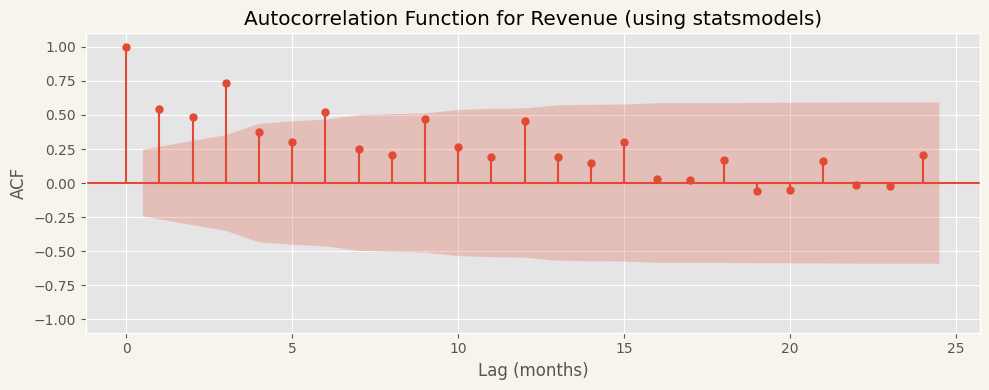

In [23]:
fig, ax = plt.subplots(figsize=(10, 4), facecolor=FACECOLOR)

plot_acf(
    y, 
    lags=24, 
    alpha=0.05, 
    ax=ax,
    title="Autocorrelation Function for Revenue (using statsmodels)",
    zero=True,
)

ax.set_xlabel("Lag (months)")
ax.set_ylabel("ACF")
ax.set_ylim(-1.1, 1.1)

plt.tight_layout()
plt.show()

We see that we implemented it correctly 🎉 Only the confidence interval is different. Our confidence interval from the previous section is the one at lag 1 in the `statsmodels` implementation.

While autocorrelation tells us how much a time series correlates with it's **own past values**, it doesn't tell us **WHY** that correlation exists - it might be indirect, caused by earlier lags. This is where $\textbf{Partial Autocorrelation}$ comes in. We will implement this from scratch in the next section.

# Partial Autocorrelation

Let's talk about the intuition first. The $\textbf{Partial Autocorrelation}$ at lag $k$, denoted as $\phi_k$, does the same as the autocorrelation with a small twist:
> It measures the effect of $y_{t-k}$ on $y_t$, but compared the the autocorrelation, it **removes the influence of all intermediate lags** $y_{t-1}, y_{t-2}, \dots, y_{t-k+1}$.

It is like asking: *"If I already know values at lags $1$ through $k-1$, how much extra predictive power does lag $k$ add?"*

The $\textbf{Partial Autocorrelation}$ **at lag** $k$ is simply the coefficient $\beta_k$ from the linear regression: 
$$
    y_t = \beta_1y_{t-1} + \beta_2y_{t-2} + \cdots + {\color{green}{\beta_k}}y_{t-k} + \epsilon_t
$$
The coefficient $\beta_k$ tells us the **isolated contribution** of $y_{t-k}$. That's the partial autocorrelation and therefore:
$$
    \color{green}{\text{PACF}(k) = \beta_k}
$$

## PACF from Scratch

To implement PACF from scratch we need to use techniques from linear algebra. 

**(1)**: Given a time series $y = [y_1, y_2, \dots, y_n]$, we want to estimate this regression for lag $k$: 
$$
    y_t = \beta_1y_{t-1} + \beta_2y_{t-2} + \cdots + \beta_ky_{t-k} + \epsilon_t
$$
which is a multiple linear regression. We need to since we are interested in the coefficient $\beta_k$ which describes the PACF at lag $k$. 

**(2)**: Now we create the regression matrix. We create 
- a target vector $\mathbf{y} \in \mathbb{R}^{n-k}$
$$
    \mathbf{y} = [y_1, y_2, \dots, y_n]
$$
- a predictor matrix $\mathbf{X} \in \mathbb{R}^{(n-k) \times k}$ where each row contains the past $k$ values:
$$
    X = \begin{bmatrix}
            y_{k-1} & y_{k-2} & \cdots & y_0 \\
            y_{k} & y_{k-1} & \cdots & y_1 \\
            \vdots  & \vdots  &        & \vdots \\
            y_{n-2} & y_{n-3} & \cdots & y_{n-k-1} \\
        \end{bmatrix}
$$
Usually, we also add a column of ones to account for the intercept $\beta_0$.

Now we want to find the coefficients ($\beta$) which minimze the total squared error
$$
    \min_{\beta}\sum_{i=1}^{n}(y_i - (X\beta)_i)^2
$$
which is equivalent to:

$$
    \min_{\beta} || y - X\beta ||^2
$$
which means we are trying to make $X\beta$, the predicted values, **as close as possible** to the actual $y$. And since X is the given data, everything we can change is $\beta$. Thus, we need to estimate $\beta$ which we will do using OLS.

**(3)**: Now we fit the model using OLS (Ordinary Least Squares). OLS is used because it finds the best-fitting linear model by minimizing the squared differences between the actual and predicted values. OLS gives a closed-form solution (which is the of setting the gradient of the squared loss function from above to zero):
$$
    \mathbf{\hat{\beta}} = (X^TX)^{-1}X^Ty
$$
which gives us the estimates for all the coefficients: 
$$
    \mathbf{\hat{\beta}} = [\beta_0, \beta_1, \dots, \beta_k]
$$

Now each $\beta_j, j={1, \dots, k}$ tells us **how much that feature (or lag)** contributes to precicting the target $y$, **while controlling for all the others**. In PACF, this means that $\beta_k$ gives us the **direct correlation** of $y_{t-k}$ with $y_t$, excluding effects of intermediate lags. 


In [24]:
y = data['Revenue'].dropna().values
max_lag = 24
n = len(y)

Let's take a look at the first couple of Revenue (`y`) data to explain what we are going to do.

In [25]:
print(y.shape)
pd.Series(y[:6]).apply(lambda x: round(x))

(64,)


0    16010072
1    15807587
2    22047146
3    18814583
4    14021480
5    16783929
dtype: int64

$\textbf{FIRST}$, we are preparing the data for regression: 
- $\mathbf{Y}$: target vector - the "current" values $y_t$
- $\mathbf{X_{\text{full}}}$: matrix of lags - the predictors $[y_{t-1}, y_{t-2}, \dots, y_{t-k}]$

To simplify the explanation, let's assume the `Revenue` (target $y$) is only the first two digits from the snipped above. Then we would have: 
$$
    y = [16, 15, 22, 18, 14, 16]
$$
Then creating a lagged matrix for the example of lag $k=3$ would result in something like this: 
$$
    \mathbf{Y} = \begin{bmatrix}
                    18 \\ 
                    14 \\
                    16
                 \end{bmatrix}
    \qquad 
    \mathbf{X}_{\text{full}} = \begin{bmatrix}
            22 & 15 & 16 \\
            18 & 22 & 15 \\ 
            14 & 18 & 22
        \end{bmatrix} \in \mathbb{R}^{k \times k}
$$
where each for is: 
- Lag 1 (most recent): 1st column
- Lag 2: 2nd column
- Lag 3: 3rd column

In [26]:
# Build lagged matrix
def create_lagged_matrix(y, max_lag):
    Y = []
    X = []
    for t in range(max_lag, len(y)):
        Y.append(y[t])
        X.append(y[t - max_lag:t][::-1])  # reverse to [y_{t-1}, ..., y_{t-k}]
    return np.array(Y), np.array(X)

Before we continue, let's quickly check if we actually did what we explained above for the case of $k=3$.

In [27]:
create_lagged_matrix(y[:6], 3)

(array([18814583.29428 , 14021479.611678, 16783928.522112]),
 array([[22047146.023644, 15807587.449808, 16010072.1195  ],
        [18814583.29428 , 22047146.023644, 15807587.449808],
        [14021479.611678, 18814583.29428 , 22047146.023644]]))

It worked! We created the $\mathbf{Y}$ and $\mathbf{X_{\text{full}}}$ from above (note that we only took the first two digits above, but the actual revenue numbers are much larger as you can see). 

$\textbf{SECOND}$, we add a column of 1s (bias term) to the matrix. This acts as the intercept: 
$$
    \mathbf{X}_{\text{full}} = \begin{bmatrix}
        1 & 22 & 15 & 16 \\
        1 & 18 & 22 & 15 \\ 
        1 & 14 & 18 & 22
    \end{bmatrix} \in \mathbb{R}^{k \times k+1}
$$
$\textbf{THIRD}$, we perform the OLS estimation as explained at the beginning of this chapter. 

$\textbf{FOURTH}$, we just extract the PACF which is the **last coefficient** $\beta_k$.

In [28]:
pacf_values = [1.0]  # PACF(0) = 1 by definition

# We estimate the PACF for lags (months) k=1,2,...,24
for k in range(1, max_lag + 1):
    
    ### FIRST ###
    #   - Create lagged matrix
    Y, X_full = create_lagged_matrix(y, k)

    ### SECOND ###
    #   - Add intercept column of only ones
    X = np.column_stack((np.ones(X_full.shape[0]), X_full))

    ### THIRD ###
    #   - Now we estimate beta_hat using Ordinary Least Squares, which 
    #     only needs the given X and y.
    #   - OLS: beta_hat = (X^T X)^(-1) X^T y
    beta = np.linalg.inv(X.T @ X) @ X.T @ Y

    ### FOURTH ###
    #   - PACF(k) is the coefficient on lag_k (last in the beta vector)
    pacf_k = beta[-1]
    pacf_values.append(pacf_k)

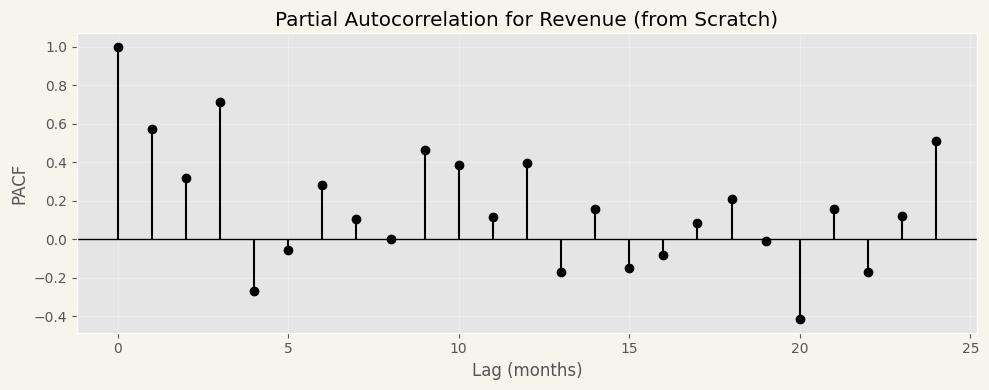

In [29]:
# Plot
lags = np.arange(0, max_lag + 1)

plt.figure(figsize=(10, 4), facecolor=FACECOLOR)
plt.stem(lags, pacf_values, basefmt=" ", linefmt='k-', markerfmt='ko')
plt.axhline(0, color='black', linewidth=1)
plt.title("Partial Autocorrelation for Revenue (from Scratch)")
plt.xlabel("Lag (months)")
plt.ylabel("PACF")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## PACF from Library

In [30]:
pacf_values = [1.0]  # lag 0 is always 1

df = pd.DataFrame({'y': y})
for lag in range(1, max_lag + 1):
    df[f'lag_{lag}'] = df['y'].shift(lag)  # proper time series lagging

df = df.dropna().reset_index(drop=True)

pacf_values = [1.0]
for k in range(1, max_lag + 1):
    X = df[[f'lag_{i}' for i in range(1, k + 1)]]
    y_target = df['y']
    X = sm.add_constant(X)
    model = sm.OLS(y_target, X).fit()
    pacf_k = model.params[f'lag_{k}']
    pacf_values.append(pacf_k)

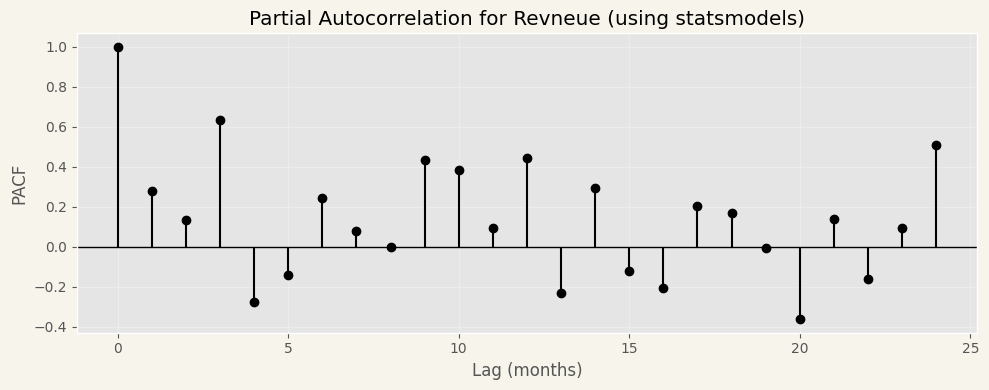

In [31]:
lags = np.arange(0, max_lag + 1)

plt.figure(figsize=(10, 4), facecolor=FACECOLOR)
plt.stem(lags, pacf_values, basefmt=" ", linefmt='k-', markerfmt='ko')
plt.axhline(0, color='black', linewidth=1)
plt.title("Partial Autocorrelation for Revneue (using statsmodels)")
plt.xlabel("Lag (months)")
plt.ylabel("PACF")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

It worked 🎉 We see that the `statsmodels` implementation is results in exactly the same results as our from-scratch implementation from the last chapter.